In [1]:
import pandas as pd
import numpy as np
import re

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.layers.embeddings import Embedding
from keras.utils.data_utils import get_file
from keras.models import Model
from keras.layers import Input, Embedding, merge ,LSTM, Dropout, concatenate, Dense, BatchNormalization, Lambda, TimeDistributed, Dot, dot
import keras.backend as K
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

from zipfile import ZipFile
from os.path import expanduser, exists

import datetime
import time

In [2]:
import json

In [3]:
import seaborn as sns

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_dataset = pd.read_csv('/content/drive/MyDrive/train.csv.zip')
train_dataset.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# Analysis of data

In [6]:
train_df_copy = train_dataset.copy()
train_df_copy.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614503,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [7]:
train_df_copy[train_df_copy['is_duplicate'] > 0].describe()

,id,qid1,qid2,is_duplicate
count,149263.000000,149263.000000,149263.000000,149263.0
mean,200804.505839,166297.474706,166591.079142,1.0
std,116180.195223,148197.861544,148272.329781,0.0
min,5.000000,11.000000,12.000000,1.0
25%,100168.000000,40367.500000,40526.000000,1.0
50%,200448.000000,118410.000000,118114.000000,1.0
75%,301239.500000,266092.000000,266916.500000,1.0
max,404286.000000,537926.000000,537927.000000,1.0


Total number of unique questions whose duplicates we have

In [8]:
len(train_df_copy[train_df_copy['is_duplicate'] > 0]['qid1'].unique())

86197

Total number of unique questions


In [9]:
import matplotlib.pyplot as plt

In [10]:
len(train_df_copy['qid1'].unique())

290654

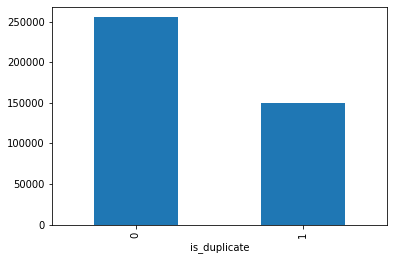

In [11]:
train_df_copy.groupby("is_duplicate")['id'].count().plot.bar()

In [12]:
print('-->> Question pairs are not Similar (is_duplicate = 0):\n     {}%'.format(100 - round(train_df_copy['is_duplicate'].mean()*100, 2)))
print('-->> Question pairs are Similar (is_duplicate = 1):\n     {}%'.format(round(train_df_copy['is_duplicate'].mean()*100, 2)))

-->> Question pairs are not Similar (is_duplicate = 0):
     63.08%
-->> Question pairs are Similar (is_duplicate = 1):
     36.92%


In [13]:
qids = pd.Series(list(train_df_copy['qid1']) + list(train_df_copy['qid2'])) #Creating a dataframe that contains the question id of both quid1 and quid2
unique_qs = len(np.unique(qids))  #Numpy array to filter down all qniue elements
qs_morethan_onetime = np.sum(qids.value_counts() > 1)   # Counts any question that have been repeated more than one time
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))



print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,round(qs_morethan_onetime/unique_qs*100,2)))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) # Taking the frequency of all question and printing the max of them

q_vals=qids.value_counts()
print(q_vals)

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.78%)

Max number of times a single question is repeated: 157

2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
416446      1
416444      1
416441      1
416439      1
537933      1
Length: 537933, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


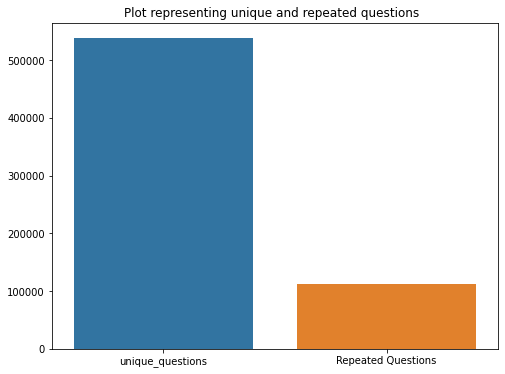

In [14]:
a = ["unique_questions" , "Repeated Questions"]
b =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(8, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(a,b)
plt.show()

Maximum number of times a single question is repeated: 157



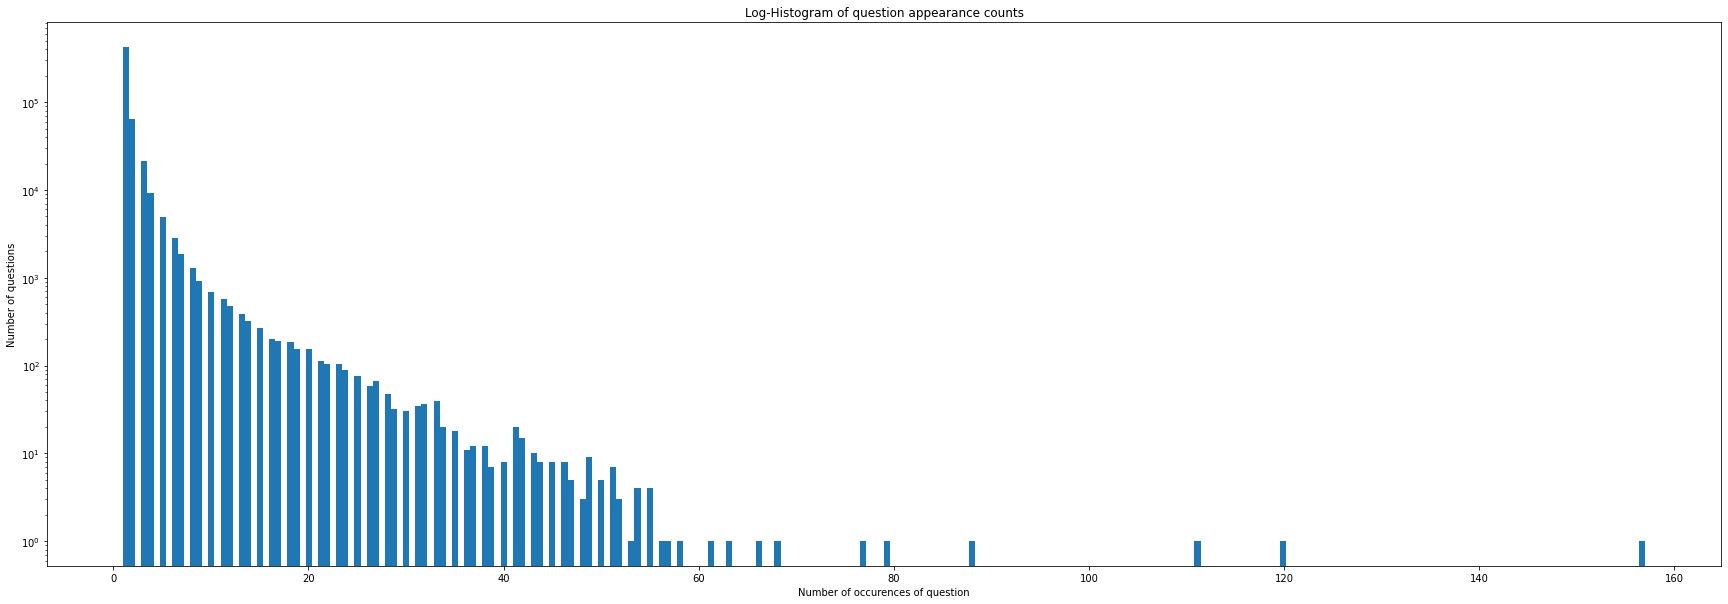

In [15]:
plt.figure(figsize=(30, 10))

plt.hist(qids.value_counts(), bins=250)

plt.yscale('log')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

# Pre-processing


Prepare a list of all vocabulary words

In [16]:
train_df = train_dataset.copy()

In [17]:
q1_set = set(train_df['question1'].unique())
q2_set = set(train_df['question2'].unique())
all_ques_list = q1_set | q2_set
len(all_ques_list)

537361

In [18]:
q1_list = train_df['question1'].tolist()
q1_list = [str(ques) for ques in q1_list]
q2_list = train_df['question2'].tolist()
q2_list = [str(ques) for ques in q2_list]
is_duplicate_list = train_df['is_duplicate'].tolist()

print(q1_list[0],":",q2_list[0],":",is_duplicate_list[0])

What is the step by step guide to invest in share market in india? : What is the step by step guide to invest in share market? : 0


In [19]:
all_questions_list = q1_list + q2_list
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(all_questions_list)

q1_word_seq = tokenizer.texts_to_sequences(q1_list)
q2_word_seq = tokenizer.texts_to_sequences(q2_list)
word_index = tokenizer.word_index

print("Words in index: %d" % len(word_index))

Words in index: 95596


In [20]:
# Save the tokenizer word index we've gotten for later

dictionary = word_index
# Let's save this out so we can use it later
with open('dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)

In [21]:
GLOVE_DOWNLOAD_URL = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'

if not exists(expanduser('~/.keras/datasets/glove.840B.300d.zip')):
    zipfile = ZipFile(get_file('glove.840B.300d.zip', GLOVE_DOWNLOAD_URL))
    zipfile.extract('glove.840B.300d.txt', path=expanduser('~/.keras/datasets/'))
    
print("Processing", 'glove.840B.300d.txt')

embeddings_index = {}

with open(expanduser('~/.keras/datasets/glove.840B.300d.txt'), encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings: %d' % len(embeddings_index))

2176778240/2176768927 [==============================] - 410s 0us/step
Processing glove.840B.300d.txt
Word embeddings: 2196016


In [22]:
len(embeddings_index['the'])

300

In [23]:
MAX_NB_WORDS = 100000
EMBEDDING_DIM = 300


nb_words = min(MAX_NB_WORDS, len(word_index))
word_embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector

print('Null word embeddings: %d' % np.sum(np.sum(word_embedding_matrix, axis=1) == 0))

Null word embeddings: 29276


In [24]:
q1_word_seq[0:5]

[[2, 3, 1, 1222, 57, 1222, 2581, 7, 576, 8, 763, 383, 8, 35],
 [2, 3, 1, 559, 10, 14300, 13598, 5, 21311, 4565],
 [4, 13, 5, 217, 1, 440, 10, 17, 361, 1827, 200, 146, 6, 2773],
 [16, 72, 5, 2774, 312, 2757, 4, 13, 5, 649, 19],
 [23, 49, 7131, 8, 231, 35496, 1891, 2047, 10570, 12, 1928, 10924, 6456]]

In [25]:
max_seq_length = 0
for ques in q1_word_seq:
    if(len(ques) > max_seq_length):
        max_seq_length = len(ques)
max_seq_length

127

In [26]:
MAX_SEQUENCE_LENGTH = 130

q1_data = pad_sequences(q1_word_seq, maxlen=MAX_SEQUENCE_LENGTH)
q2_data = pad_sequences(q2_word_seq, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(is_duplicate_list, dtype=int)
print('Shape of question1 data tensor:', q1_data.shape)
print('Shape of question2 data tensor:', q2_data.shape)
print('Shape of label tensor:', labels.shape)

Shape of question1 data tensor: (404290, 130)
Shape of question2 data tensor: (404290, 130)
Shape of label tensor: (404290,)


In [27]:
q1_data[0:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     2,
            3,     1,  1222,    57,  1222,  2581,     7,   576,     8,
      

In [28]:
X = np.stack((q1_data, q2_data), axis=1)
y = labels
X.shape

(404290, 2, 130)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]
Q1_train.shape

(323432, 130)

In [30]:
Q1_train

array([[    0,     0,     0, ...,    41, 23893,  1091],
       [    0,     0,     0, ...,    82,    19,   251],
       [    0,     0,     0, ...,    10,  4830,   585],
       ...,
       [    0,     0,     0, ..., 33565, 22298,   170],
       [    0,     0,     0, ...,     6,  7802,  3797],
       [    0,     0,     0, ...,     7,  3189, 30510]], dtype=int32)

In [31]:
Q1_train.shape

(323432, 130)

In [32]:
NUM_HIDDEN_UNITS_LAYER1 = 50
NUM_HIDDEN_UNITS_LAYER2 = 100

question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

embedding_layer = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)

q1 = embedding_layer(question1)
q2 = embedding_layer(question2)

lstm_first = LSTM(NUM_HIDDEN_UNITS_LAYER1, return_sequences=False)

q1 = lstm_first(q1)
q2 = lstm_first(q2)

dropout_layer = Dropout(0.2)

q1 = dropout_layer(q1)
q2 = dropout_layer(q2)

dense = Dense(100, activation='relu')
dropout_two = Dropout(0.2)
bn_one = BatchNormalization()

q1 = dense(q1)
# q1 = dropout_two(q1)
# q1 = bn_one(q1)
q2 = dense(q2)
# q2 = dropout_two(q2)
# q2 = bn_one(q2)

merged = concatenate([q1,q2])
is_duplicate = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=is_duplicate)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 130)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 130)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 130, 300)     28679100    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 50)           70200       ['embedding[0][0]',          

In [33]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

In [ ]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint('question_pairs_weights_type1_final_new.h5', monitor='val_acc', save_best_only=True)]
history = model.fit([Q1_train, Q2_train],
                    y_train,
                    epochs=10,
                    validation_data=([Q1_test, Q2_test], y_test),
                    verbose=1,
                    batch_size=512,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2022-09-21 04:42:37.454127
Epoch 1/10
632/632 [==============================] - ETA: 0s - loss: 0.5514 - accuracy: 0.7203

632/632 [==============================] - 979s 2s/step - loss: 0.5514 - accuracy: 0.7203 - val_loss: 0.5201 - val_accuracy: 0.7449
Epoch 2/10
632/632 [==============================] - ETA: 0s - loss: 0.5124 - accuracy: 0.7498

632/632 [==============================] - 1024s 2s/step - loss: 0.5124 - accuracy: 0.7498 - val_loss: 0.5047 - val_accuracy: 0.7550
Epoch 3/10
632/632 [==============================] - ETA: 0s - loss: 0.4954 - accuracy: 0.7606

632/632 [==============================] - 1030s 2s/step - loss: 0.4954 - accuracy: 0.7606 - val_loss: 0.4976 - val_accuracy: 0.7601
Epoch 4/10
632/632 [==============================] - ETA: 0s - loss: 0.4848 - accuracy: 0.7677

632/632 [==============================] - 1030s 2s/step - loss: 0.4848 - accuracy: 0.7677 - val_loss: 0.4944 - val_accuracy: 0.7627
Epoch 5/10
632/632 [==============================] - ETA: 0s - loss: 0.4749 - accuracy: 0.7737

632/632 [==============================] - 1041s 2s/step - loss: 0.4749 - accuracy: 0.7737 - val_loss: 0.4864 - val_accuracy: 0.7682
Epoch 6/10
632/632 [==============================] - ETA: 0s - loss: 0.4660 - accuracy: 0.7800

632/632 [==============================] - 970s 2s/step - loss: 0.4660 - accuracy: 0.7800 - val_loss: 0.4885 - val_accuracy: 0.7705
Epoch 7/10
632/632 [==============================] - ETA: 0s - loss: 0.4587 - accuracy: 0.7841

632/632 [==============================] - 948s 1s/step - loss: 0.4587 - accuracy: 0.7841 - val_loss: 0.4812 - val_accuracy: 0.7716
Epoch 8/10
632/632 [==============================] - ETA: 0s - loss: 0.4520 - accuracy: 0.7884

632/632 [==============================] - 938s 1s/step - loss: 0.4520 - accuracy: 0.7884 - val_loss: 0.4837 - val_accuracy: 0.7681
Epoch 9/10
601/632 [===========================>..] - ETA: 41s - loss: 0.4451 - accuracy: 0.7921

In [ ]:
# evaluate the model
loss, acc = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

In [ ]:
label=[Q1_test, Q2_test]
label

In [38]:
y_pred=model.predict(label)

In [39]:
def prediction(y_pred):
  for i in range(len(y_pred)):
    if y_pred[i] > 0.5:
      y_pred[i]=1
    else:
      y_pred[i]=0  
  return y_pred    

In [40]:
prediction(y_pred).flatten().astype(int)

array([1, 0, 0, ..., 0, 0, 0])

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
confusion_mtx=confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83     51060
           1       0.72      0.64      0.68     29798

    accuracy                           0.77     80858
   macro avg       0.76      0.75      0.75     80858
weighted avg       0.77      0.77      0.77     80858

0.7745059239654704


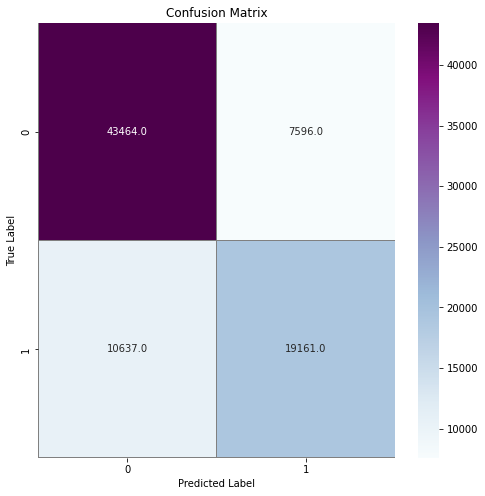

In [42]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

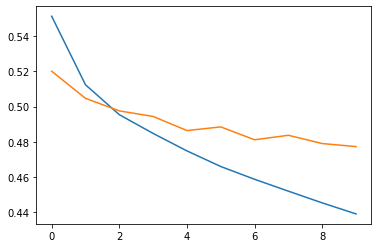

In [43]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss']) # loss is training loss
plt.plot(history.history['val_loss']) # val_loss loss on the validation data / test loss

# Testing model

In [44]:
from keras.preprocessing.text import text_to_word_sequence

In [45]:
def convert_text_to_index_array(text, dictionary):
  words=text_to_word_sequence(text)
  wordIndices=[]
  for word in words:
    if word in dictionary:
      wordIndices.append(dictionary[word])
    else:
      print("'%s' not in training corpus; ignoring." %(word))
  return wordIndices      

In [46]:
def question_pair(question1,question2):

  question1=input()
  question2=input()
  q1_word_seq = convert_text_to_index_array(question1,dictionary)
  q1_word_seq = [q1_word_seq]
  q2_word_seq = convert_text_to_index_array(question2,dictionary)
  q2_word_seq = [q2_word_seq]
  q1_data = pad_sequences(q1_word_seq, maxlen=MAX_SEQUENCE_LENGTH)
  q2_data = pad_sequences(q2_word_seq, maxlen=MAX_SEQUENCE_LENGTH)

  pred = model.predict([q1_data,q2_data])
  return pred

In [ ]:
print(question_pair('how old are you?','what is your age?'))

# model 2

In [ ]:
def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [ ]:
question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

q1 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question1)
q1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q1)
q1 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q1)

q2 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question2)
q2 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q2)
q2 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q2)

merged = concatenate([q1,q2])
merged = Dense(200, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)

is_duplicate = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=is_duplicate)


In [ ]:
model.summary()

In [ ]:
#model compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint('question_pairs_weights.h5', monitor='val_acc', save_best_only=True)]
history = model.fit([Q1_train, Q2_train],
                    y_train,
                    epochs=10,
                    validation_data=([Q1_test, Q2_test], y_test),
                    verbose=1,
                    batch_size=64,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

In [ ]:
# evaluate the model
loss, acc = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

# testing new model

In [ ]:
def convert_text_to_index_array(text, dictionary):
  words=text_to_word_sequence(text)
  wordIndices=[]
  for word in words:
    if word in dictionary:
      wordIndices.append(dictionary[word])
    else:
      print("'%s' not in training corpus; ignoring." %(word))
  return wordIndices      

In [ ]:
question1 = "What's python programming?"
question2 = "What's in python programming?"

q1_word_seq = convert_text_to_index_array(question1,dictionary)
q1_word_seq = [q1_word_seq]
q2_word_seq = convert_text_to_index_array(question2,dictionary)
q2_word_seq = [q2_word_seq]
q1_data = pad_sequences(q1_word_seq, maxlen=MAX_SEQUENCE_LENGTH)
q2_data = pad_sequences(q2_word_seq, maxlen=MAX_SEQUENCE_LENGTH)

pred = model.predict([q1_data,q2_data])
print(pred)

In [ ]:
question1 = "How to learn english?"
question2 = "Why can't I sing?"

q1_word_seq = convert_text_to_index_array(question1,dictionary)
q1_word_seq = [q1_word_seq]
q2_word_seq = convert_text_to_index_array(question2,dictionary)
q2_word_seq = [q2_word_seq]
q1_data = pad_sequences(q1_word_seq, maxlen=MAX_SEQUENCE_LENGTH)
q2_data = pad_sequences(q2_word_seq, maxlen=MAX_SEQUENCE_LENGTH)

pred = model.predict([q1_data,q2_data])
print(pred)

In [ ]:
def question_pair(question1,question2):

  question1=input()
  question2=input()
  q1_word_seq = convert_text_to_index_array(question1,dictionary)
  q1_word_seq = [q1_word_seq]
  q2_word_seq = convert_text_to_index_array(question2,dictionary)
  q2_word_seq = [q2_word_seq]
  q1_data = pad_sequences(q1_word_seq, maxlen=MAX_SEQUENCE_LENGTH)
  q2_data = pad_sequences(q2_word_seq, maxlen=MAX_SEQUENCE_LENGTH)

  pred = model.predict([q1_data,q2_data])
  return pred

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss']) # loss is training loss
plt.plot(history.history['val_loss']) # val_loss loss on the validation data / test loss

In [ ]:
import pickle

In [ ]:
#pickle.dump(model,open('model.pkl','wb'))

In [ ]:
label=[Q1_test, Q2_test]
label

In [ ]:
y_pred=model.predict(label)  

In [ ]:
y_pred

In [ ]:
def hi(y_pred):
  for i in range(len(y_pred)):
    if y_pred[i] > 0.5:
      y_pred[i]=1
    else:
      y_pred[i]=0  
  return y_pred    

In [ ]:
hi(y_pred).flatten().astype(int)

In [ ]:
y_test

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
confusion_mtx=confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

In [ ]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import plot_roc_curve
#plot_roc_curve(rfc, X_val, Y_val)